# Solving the quantum many-body problem with NQS
## 1D Transverse Field Ising (TFI) model 

In [1]:
# Initialize NQS
import numpy as np  

# Generate NN nodes.
N =  4
alpha = 2 
M = alpha * N  

# External magnetic field
h = 2  

# Initialize the weights and biases
def random_complex(size): 
    a = (np.random.random(size) - .5) * 10e-2  
    b = (np.random.random(size) - .5) * 10e-2  # random number -0.005~0.005
    return a + 1j*b  
a = random_complex(N)  
b = random_complex(M)  
W = random_complex((N,M)) 


Variational expression for the wave function:

$\begin{aligned} \Psi_N(\boldsymbol{S},\boldsymbol{W} ) & = \langle S|\psi\rangle=\sum_{h_j \in\{-1,1\}} \exp (\boldsymbol{a}^T \boldsymbol{S}+\boldsymbol{b}^T \boldsymbol{h}+\boldsymbol{S}^T \boldsymbol{W} \boldsymbol{h}) \\ & =\exp (\boldsymbol{a}^T \boldsymbol{S}) \prod_j^{M} 2 \cosh (\theta_j)\end{aligned}$

where the effective angle $\theta_j(\mathcal{S})=b_j+\sum_i  W_{i j}\sigma_i$.

In [2]:
# define wave function
def theta(Spin):  
    return b + W.T @ Spin  

def Psi_M(Spin):  
    return np.exp(a @ Spin) * np.prod(2*np.cosh(theta(Spin)))  

Hamiltonian of 1D transverse field Ising model:
$$H_{\text{TFI}}= - \sum_{ij}\sigma_i^z\sigma_j^z -h\sum_i \sigma_i^x$$

Calculating the local energy for a state $\mathcal{S}$,

$$E_\text{loc}=\frac{\langle\mathcal{S}|H|\Psi_M\rangle}{\langle\mathcal{S}|\Psi_M\rangle}=\frac{\sum_{S'}\Psi_M(S')\langle\mathcal{S}|H|S'\rangle}{\Psi_M(\mathcal{S})}$$


In [3]:
# define local energy
def E_local(State):
    # \sigma^z part : scan all the sites
    State=np.array(State)

    E_z = 0 
    for i in range(N): 
        if i == N-1:  
            E_z+=(State[i]*State[0])  
        else:
            E_z+=(State[i]*State[i+1])  
    E_z = -1*E_z
    
    E_x= 0
    # 只有和自己只差一个spin的会留下来
    for i in range(N):  
        State[i] *= -1  
        E_x += Psi_M(State)
        State[i] *= -1  # 恢复原值
    E_x = -h*E_x/Psi_M(State)  # 除以波函数

    E_total= E_z + E_x 
    return E_total/N  # 返回E除以N的值作为局部能量

In [4]:
# Import the product function to generate all possible basis states
from itertools import product

# Generate all possible basis states
basis = list(product([1,-1],repeat=N))


# Calculate the local energy for each basis state
E = [E_local(basis[i]) for i in range(2**N)]

# Calculate the average local energy
avg_E_local = np.mean(E)
print("The average local energy is: ", avg_E_local)

The average local energy is:  (1.9996663768572505-0.0034160296189508117j)


Markov chain sampling
$$S_0 \xrightarrow[and \ judge]{flip \ a \ spin} S_1 \rightarrow S_2 \rightarrow S_3 \rightarrow S_4 \rightarrow \cdots$$
$$P(\text{accept})=\frac{\Psi_M(\mathcal{S}_\text{new})\Psi^*_M(\mathcal{S}_\text{new})}{\Psi_M(\mathcal{S}_\text{old})\Psi^*_M(\mathcal{S}_\text{old})}$$

In [5]:
# MCMC sampling
def MCMC_sampling(Spin):
    # Choose random sites to be flipped
    sites = np.random.choice(N, size=1, replace=False)
    Psi_M_before = Psi_M(Spin)  
    for i in sites:  
        Spin[i] *= -1
    Psi_M_after = Psi_M(Spin) 
    acceptance = np.real(Psi_M_after*np.conj(Psi_M_after)/(Psi_M_before*np.conj(Psi_M_before))) 

    # <U, reject
    if acceptance < np.random.uniform():  
        for i in sites:  
            Spin[i] *= -1 
        return 1 
    # <U, accept
    else:
        return 0  

Keep track of $\nabla_\mathcal{W}E_\text{loc}$ and use these to update $\mathcal{W}=\{a,b,W\}$

$$\nabla_\mathcal{W}\left<E\right>=\nabla_\mathcal{W}\sum_{s}E_\text{loc}P(s)=\sum_{s}P(s)\nabla_\mathcal{W}E_\text{loc}+E_\text{loc}\nabla_\mathcal{W}P(s)$$
In this simulation we only keep track of the first term:
$$
\partial_{a_i}E_\text{loc}(S)=-h\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[2\sigma_i^z\right]
$$1
$$
\partial_{b_j}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[\tanh{\theta_j(S_\text{flip i})}-\tanh{\theta_j(S)}\right]
$$
$$
\partial_{W_{ij}}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[-\theta_i^z\tanh{\theta_j(S_\text{flip i})}-\theta_i^z\tanh{\theta_j(S)}\right]
$$

In [6]:
# Training parameters
learning_rate = 0.05  
learning_steps = 50
MCMC_sample_number = 1000


block_E = []  
# Training the network
for block_i in range(learning_steps):  
    State = np.random.choice([-1, 1], size=N)

    rejected = 0  
    array_E_loc = []  
    array_a_d = [] 
    array_b_d = []  
    array_w_d = []  

    for k in range(MCMC_sample_number):  
        rejected += MCMC_sampling(State)  
        # print(Spin)
        Psi_M_s = Psi_M(State)  

        # Derivative a
        a_deriv = np.zeros(N, dtype=np.complex_)  
        for i in range(N):  
            State[i] *= -1  
            a_deriv[i] = -h*Psi_M(State)/Psi_M_s*2.*State[i]  
            State[i] *= -1  

        # Derivative W
        dW = np.zeros((N,M),dtype=np.complex_) 
        for w_i in range(N):  
            for w_j in range(M): 
                dw_sum = 0  
                before_flip = np.tanh(theta(State))  
                for i in range(N):  
                    State[i] *= -1  
                    dw_sum += Psi_M(State)/Psi_M_s*(
                        -State[i]*np.tanh(theta(State)[w_j])-State[i]*before_flip[w_j]) 
                    State[i] *= -1  
                dw_sum *= h
                dW[w_i,w_j] = dw_sum  

        # Derivative b
        b_deriv = np.zeros(M, dtype=np.complex_)  
        for b_j in range(M):  
            tanh_before_flip = np.tanh(theta(State))  
            db_sum = 0  
            for i in range(N):  
                State[i] *= -1  
                db_sum += Psi_M(State)/Psi_M_s*(
                    np.tanh(theta(State)[b_j])-tanh_before_flip[b_j])  
                State[i] *= -1  
            b_deriv[b_j] = -h * db_sum 

        array_a_d.append(a_deriv)  
        array_b_d.append(b_deriv)  
        array_w_d.append(dW)  
        array_E_loc.append(np.real(E_local(State)))  

    print('%d. E_loc=%.4f, std=%.4f, %.1f %% rejected' % (block_i+1,
        np.mean(array_E_loc),np.std(array_E_loc)/(np.sqrt(len(array_E_loc))), 100.*rejected/MCMC_sample_number))  

    # expectation value 
    block_E.append(np.mean(array_E_loc))  
    mean_da = np.mean(np.array(array_a_d),axis=0)  
    mean_db = np.mean(np.array(array_b_d),axis=0)  
    mean_dw = np.mean(np.array(array_w_d),axis=0)  

    # Update the weights and biases
    a = a - learning_rate * mean_da  
    b = b - learning_rate * mean_db  
    W = W - learning_rate * mean_dw  

1. E_loc=1.9811, std=0.0159, 4.5 % rejected
2. E_loc=1.9916, std=0.0154, 3.8 % rejected
3. E_loc=1.9843, std=0.0155, 5.1 % rejected
4. E_loc=1.9443, std=0.0163, 4.2 % rejected
5. E_loc=1.9317, std=0.0164, 6.0 % rejected
6. E_loc=1.8834, std=0.0159, 5.8 % rejected
7. E_loc=1.8273, std=0.0161, 6.3 % rejected
8. E_loc=1.5623, std=0.0151, 6.1 % rejected
9. E_loc=1.2793, std=0.0161, 6.9 % rejected
10. E_loc=0.8086, std=0.0154, 7.5 % rejected
11. E_loc=0.2064, std=0.0152, 5.5 % rejected
12. E_loc=-0.5002, std=0.0156, 5.2 % rejected
13. E_loc=-1.1087, std=0.0156, 6.0 % rejected
14. E_loc=-1.5724, std=0.0155, 5.8 % rejected
15. E_loc=-1.8218, std=0.0158, 7.4 % rejected
16. E_loc=-1.9236, std=0.0153, 8.9 % rejected
17. E_loc=-1.9595, std=0.0158, 8.7 % rejected
18. E_loc=-1.9552, std=0.0165, 8.9 % rejected
19. E_loc=-2.0172, std=0.0164, 9.6 % rejected
20. E_loc=-1.9797, std=0.0158, 8.9 % rejected
21. E_loc=-1.9785, std=0.0152, 10.6 % rejected
22. E_loc=-1.9926, std=0.0162, 11.0 % rejected
23. E_

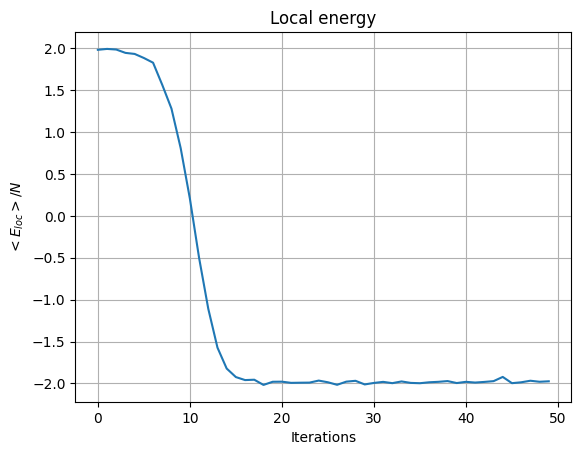

In [7]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.plot(block_E)
plt.title('Local energy')
plt.grid(True)
plt.ylabel(r'$<E_{loc}>/N$')
plt.xlabel('Iterations')
plt.show()

Find the exact ground state energy by constructing all $H_{ij}=\left<s_i\right|H\left| s_j\right>$

In [9]:
# Import the product function to generate all possible basis states
from itertools import product

# Generate all possible basis states
basis = list(product([1,-1],repeat=N))

# Initialize the Hamiltonian matrix
H = np.zeros((2**N,2**N))

# Calculate each element of the Hamiltonian matrix
for H_i in range(2**N):
    for H_j in range(2**N):
        H_ij = 0
        for i in range(N):
            if H_i == H_j:
            # sigmaz只有对角线
                if i == N-1:
                    H_ij -= basis[H_j][i]*basis[H_j][0]
                else:
                    H_ij -= basis[H_j][i]*basis[H_j][i+1]
            # sigmax非正交时起作用        
            flipped_basis_j  = list(basis[H_j])
            flipped_basis_j [i] *= -1
            if H_i == basis.index(tuple(flipped_basis_j )):
                H_ij -= h

        H[H_i,H_j] = H_ij

# Print the ground state energy
print('Ground state energy:', np.min(np.linalg.eigvals(H))/N)


Ground state energy: -2.135779205069859
